In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import random

import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
import gala.coordinates as gc

import astropy.coordinates as coord
import astropy.units as u
from astropy.table import QTable, Table
from astropy.coordinates import Galactocentric, ICRS, SkyCoord, Distance, CartesianRepresentation, SphericalRepresentation


In [2]:
coord.galactocentric_frame_defaults.set('v4.0')

<ScienceState galactocentric_frame_defaults: {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg...>

In [3]:
# host

Mh = 10 ** 11.81  # Halo mass of the host
MHI = 0.91e9
M_star = 5.9e10  # stellar mass from Rubin82, at R_25
RAH, DecH = 149.5878735, 32.3698905
dist = 25.00516842 * u.Mpc  # mpc

# satellite

m_star = 10 ** 7.17
m_gas_sf = 10 ** 7.74
m_gas_que = 10 ** 6.74
Dh = 75  # kpc
RAs, Decs = 149.6921195816266, 32.51841252708709
PA = 3.68 * u.rad  # position angle from the plane of the Host
v_sat = 65.95  # km/s LOS satellite velocity
print(PA)

# satellite luminosity
Mr_sat = -13.1538315
Mr_sol = 4.76
Lsat = 10 ** (0.4 * (Mr_sol - Mr_sat))  # In Lsol
print(np.log10(Lsat))

3.68 rad
7.165532600000001


In [4]:
# coordinates on the skY of the host, satellilte

cooH = SkyCoord(RAH * u.deg, DecH * u.deg, distance=dist)
cooSat = SkyCoord(RAs * u.deg, Decs * u.deg, distance=dist)

# distances on the sky between objects
distX = cooH.cartesian.x - cooSat.cartesian.x
distY = cooH.cartesian.y - cooSat.cartesian.y
distZ = cooH.cartesian.z - cooSat.cartesian.z


In [5]:
# coordinates frame - galactic
galcen_frame = coord.Galactocentric()


In [6]:
# central potential
potential = gp.MilkyWayPotential()


## 3D velocity assumptions

In [7]:
# we assume that the LOS velocity is all tangential

v_t = v_sat  # measured


In [8]:
def get_3D_cart_vel(vt, vr, pa, ra_or_dec = 'ra'):
    
    # Create the array of possible velocity pairs for orbit integration
    
    # algnement of Vt vector
    if ra_or_dec == 'ra' or  ra_or_dec == 'RA' or  ra_or_dec == 'Ra':
        
        # Vt along RA
        vx = 0
        vy = v_sat + vr * np.cos(PA)
        vz = vr * np.sin(PA)
        
    elif ra_or_dec == 'dec' or  ra_or_dec == 'Dec' or  ra_or_dec == 'DEC':
        
        # Vt alnong DEC
        vx = 0
        vy = vr * np.cos(PA)
        vz = v_sat + vr * np.sin(PA)
        
    v = np.array([vx,vy,vz])
    
    return v

## 3D position 

In [9]:
# 3D cartesian position

dy, dz = distY.to(u.kpc), distZ.to(u.kpc)

x = 0
y = dz.value
z = dy.value

print(x,y,z)

0 -54.701153836628436 50.704683218839364


# Orbit integration

In [34]:
# choose number of time steps
N = 6000
time_step = -0.05 * u.Mpc  # time step size

True
0.36244142101868393
-1926.0 Myr
46.4619287554122 kpc


/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/gala/dynamics/orbit.py:652: GalaDeprecationWarning: Passing radial=True in estimate_period() is now deprecated. This method now returns period estimates for all orbital components. If you want to get just the radial period, use orbits.physicsspherical.estimate_period() instead.
  warnings.warn(


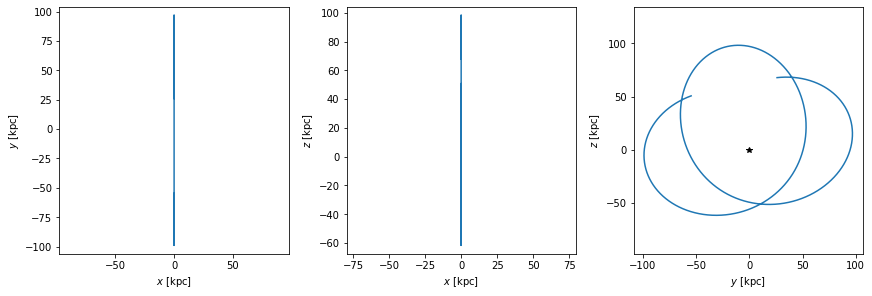

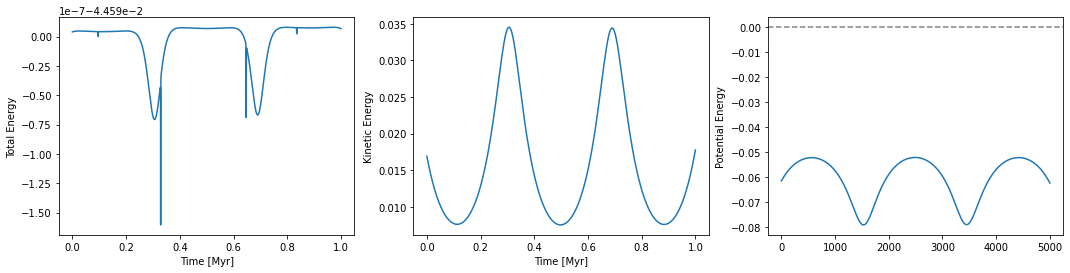

In [24]:
# select the orbit by choosing the satellite radial velocity
N = int(5. / 0.001)
vr = -120
vel = get_3D_cart_vel(v_sat, vr,PA)
w0 = gd.PhaseSpacePosition(pos=[x,y,z] * u.kpc,vel=vel * u.km/u.s)
orbit = potential.integrate_orbit(w0, dt=-1 * u.Myr, n_steps=N)

orbit.plot()
U1 = orbit.energy(potential)
plt.plot(0,0, "k*")

plt.figure(figsize=(18,4))
T = np.linspace(0,1, N+1)

plt.subplot(131)
plt.plot(T, U1)
plt.xlabel("Time [Myr]")
plt.ylabel("Total Energy")
plt.subplot(132)
plt.plot(T, orbit.kinetic_energy())
plt.xlabel("Time [Myr]")
plt.ylabel("Kinetic Energy")
plt.subplot(133)
plt.plot(orbit.potential_energy())
plt.ylabel("Potential Energy")
plt.axhline(0, ls='--', c='gray')
print(all(U1<0))
print(orbit.eccentricity())
print(orbit.estimate_period(y))
print(orbit.pericenter())
torb = -orbit.estimate_period(y)

In [25]:
# t0 is the first pericenter time

peri = orbit.pericenter(func=None, return_times=True)
t0 = peri[1][0]  # first peri
print(torb)
t1 = t0 + torb

print(t0, t1) 


1926.0 Myr
-3451.7805014174596 Myr -1525.7805014174596 Myr


## Gas

### Assumption all gas lost on one orbit (one round)

In [26]:
# we assume that gas was los steadily through the wole time, so the total gas along the orbit is now == Mgas0

In [27]:
# gas mass
m_gas = m_gas_sf  # solar masses

# dwarf looses al that gas during one orbit, evenly distribution over the orbit
mdot = m_gas_sf * (u.Msun) / torb

print(np.log10(mdot.value))

4.455343717211485


In [28]:
# start time T0 , start of the integraiton

T0 = (-1 * N)*u.Myr
print(T0,t0)
print(int(abs((T0 - t0) / u.Myr)))
a = int(abs((T0 - t0) / u.Myr))
b = int(abs((T0 - (t0 + 2 * torb)) / u.Myr))
print(a,b)

-5000.0 Myr -3451.7805014174596 Myr
1548
1548 5400


# the Particles

In [29]:
pot=potential

In [30]:
x = 0
y = dz.value
z = dy.value

In [31]:
P = torb.value
print(P)

1926.0


In [35]:


vel = get_3D_cart_vel(v_sat, vr,PA)
w0 = gd.PhaseSpacePosition(pos=[x,y,z]*u.kpc,vel=vel*u.km/u.s)
orbit = potential.integrate_orbit(w0, dt=-1 * u.Myr, n_steps=N)
orbit2 = potential.integrate_orbit(w0, dt=1 * u.Myr, n_steps=P)

In [36]:
# new initial conditions starting in peri
w0_peri = gd.PhaseSpacePosition(pos=orbit.pos[b],vel=orbit.vel[b])

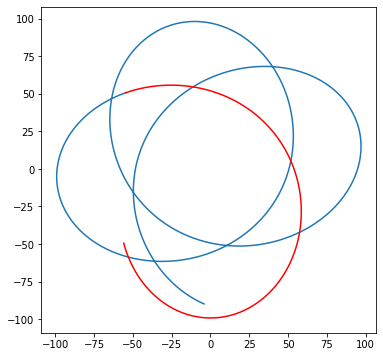

In [37]:
plt.figure(figsize=(6,6))
plt.plot(orbit.pos.y, orbit.pos.z)
plt.plot(orbit2.pos.y, orbit2.pos.z, c='r')

In [38]:
norbits = 2500
new_pos = np.random.normal(w0_peri.pos.xyz.to(u.pc).value, 2000.,  # the spread - dwarf effective radius here 2 kpc
                           size=(norbits,3)).T * u.pc
new_vel = np.random.normal(w0_peri.vel.d_xyz.to(u.km/u.s).value, 20., # velocity scale - dispersion around the orbital velocity, max rotational
                           size=(norbits,3)).T * u.km/u.s
new_ics = gd.PhaseSpacePosition(pos=new_pos, vel=new_vel)
orbits = potential.integrate_orbit(new_ics, dt=1 * u.Myr, n_steps=N)

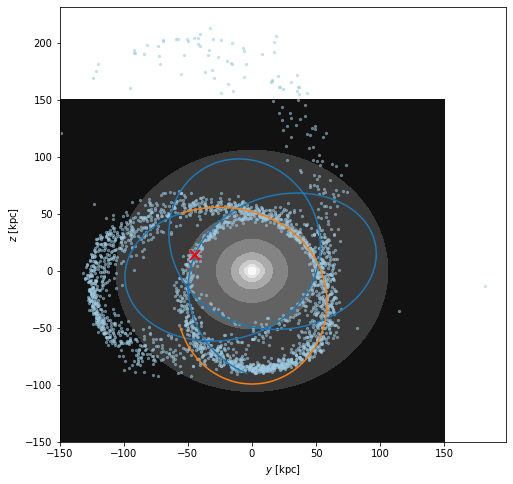

In [39]:
# plot the orbits (final positions) over the isopotential contours
grid = np.linspace(-150,150,64)
fig,ax = plt.subplots(1, 1, figsize=(8,8))
fig = pot.plot_contours(grid=(grid,grid,0), cmap='Greys', ax=ax)
fig = orbits[-1].plot(['y', 'z'], color='#9ecae1', s=20., alpha=0.5,
                       axes=[ax], auto_aspect=False) 
# for i in range(0, 3*P, 100):
#     fig = orbits[i].plot(['y', 'z'], color='#9ecae1', s=20., alpha=0.5,
#                       axes=[ax], auto_aspect=False) 
ax.plot(orbit.pos.y, orbit.pos.z)
ax.plot(orbit2.pos.y, orbit2.pos.z)
ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=10, markeredgewidth=2)
#ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=20, markeredgewidth=2)


In [40]:
# assume that all particless are equal mmass and all gas was removed instanteniusly
# for the SF gas dwarf content
m_part = m_gas_sf / norbits
print(np.log10(m_part))

4.342059991327963


## NFW + stellar potential of the satellite of a satellite 

In [41]:
## Find NFW profile, using parameters and scaling rlation from Tollerud 2011

In [42]:
L12 = Lsat / 2.  # L_1/2 = L /2 
#similarly we can calculate the r1/2 but I don't have Re so I will use the scaling relations
r12 =  0.1 # kpc
M12 = m_star # virtually same as the msat
print(f"L1/2 {np.log10(L12):.2f} r1/2 {r12:.2f} kpc M1/2 {np.log10(M12):.2f} Msol")

L1/2 6.86 r1/2 0.10 kpc M1/2 7.17 Msol


In [43]:
# in this regime Re will be 
Re = 3./4. * r12
print(f"Re {Re:.2f} kpc")

Re 0.08 kpc


In [44]:
# from the relations between L12 and M12DM
Mvir_DM = 10**10
h=0.7

In [45]:
# concentration

c = 12. * (Mvir_DM / 10**12 / (1/h))** (-0.075)
print(c)

17.41000488790022


In [48]:

sat_pot = gp.NFWPotential.from_M200_c(10**8 *u.Msun,c, units=galactic)

In [49]:
## Folowing only forces from Adrian's code first withouth the dwarf self interqaction


In [50]:
def F_nodrag_nosat(t, w):
    # position units are in kpc
    # velocity units here are in kpc/Myr
    x, y, z, vx, vy, vz = w
    
    q = np.stack((x, y, z), axis=1)
    p = np.stack((vx, vy, vz), axis=1)
    
    # compute acceleration from milky way:
    _t = np.array([0.])
    acc = -pot._gradient(q, _t).T
    
    acc[:, 0] = acc[:, 0] 
    
    return np.vstack((p.T, acc))

In [51]:
# Compute the orbit in a Milky Way model without drag by integrating backwards in time

#starting position ofhte satelite and particles - peri

w0_peri  #satellite
print(w0_peri)

#starting position of gas particles in peri
norbits = 2500
new_pos = np.random.normal(w0_peri.pos.xyz.to(u.kpc).value, 2*u.kpc,  # the spread - dwarf effective radius here 2 kpc
                           size=(norbits,3)).T * u.kpc
new_vel = np.random.normal(w0_peri.vel.d_xyz.to(u.kpc/u.Myr).value, (20. *u.km/u.s).to(u.kpc/u.Myr), # velocity scale - dispersion around the orbital velocity, max rotational
                           size=(norbits,3)).T * u.kpc/u.Myr
new_ics = gd.PhaseSpacePosition(pos=new_pos, vel=new_vel)
print(new_ics)

pos=(0., -44.41921472, 14.11258913) kpc
vel=(0., 0.09251443, 0.24591412) kpc / Myr
pos=[(-2.29706496, -46.95665477, 14.52643375),
 (-0.84627858, -46.92586679, 14.91046714),
 (-0.69244009, -45.63110584, 17.63838558), ...,
 (-2.0618236 , -47.71966388, 11.64364927),
 (-0.4298027 , -43.60985905, 17.09881976),
 ( 0.37241769, -38.75589996, 12.36179145)] kpc
vel=[( 0.01596382, 0.0743745 , 0.29353783),
 (-0.02556743, 0.0908088 , 0.23785332),
 ( 0.01353793, 0.09601999, 0.22491777), ...,
 ( 0.00192542, 0.11849905, 0.24596618),
 ( 0.00505055, 0.10368171, 0.23833563),
 ( 0.03169479, 0.07002121, 0.2809683 )] kpc / Myr


In [52]:
# compute the orbit  forwards
integrator = gi.DOPRI853Integrator(F_nodrag_nosat, func_units=galactic)
orbits_nodrag_nosat = integrator.run(gd.combine((new_ics, w0_peri)), 
                               dt=1, t1=0, t2=2*P) #dt step in Myr, from 0 to 2 orbits


In [53]:
orbit_nodrag_nosat = orbits_nodrag_nosat[:, :-1]
orbit_sat_nosat = orbits_nodrag_nosat[:, -1]

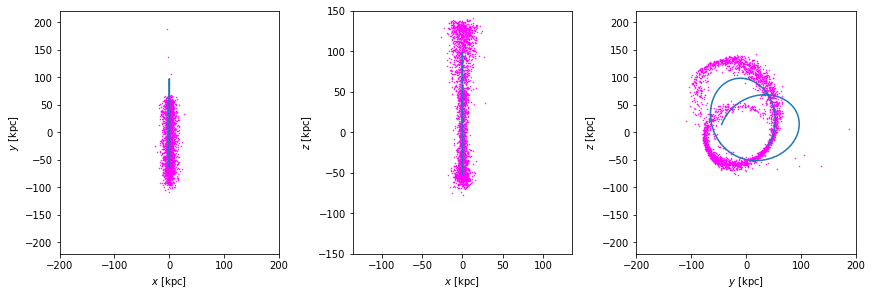

In [54]:
fig = orbit_nodrag_nosat[-1].plot(s=1, c='magenta')
_ = orbit_sat_nosat.plot(axes=fig.axes)
for ax in fig.axes:
    ax.set_xlim(-200, 200)
    ax.set_ylim(-150, 150)
    
# this is just a biunch of points propagatingin MW potential. 

Text(0.5, 1.0, 'No drag and no satellite gravity')

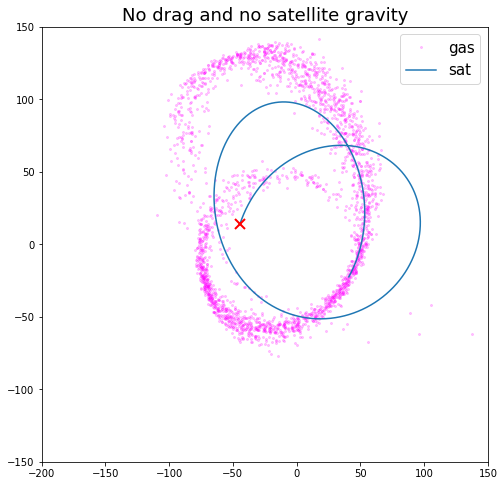

In [55]:
fig,ax = plt.subplots(1, 1, figsize=(8,8))
#fig = pot.plot_contours(grid=(grid,grid,0), cmap='Greys', ax=ax)
# fig = orbits_nodrag_nosat[-1].plot(['z', 'y'], color='magenta', s=20., alpha=0.2,
#                        axes=[ax], auto_aspect=False) 
plt.plot(orbits_nodrag_nosat[-1].pos.y, orbits_nodrag_nosat[-1].pos.z, 'o', color='magenta', ms=2., alpha=0.2,label='gas')
ax.plot(orbit_sat_nosat.pos.y, orbit_sat_nosat.pos.z, label='sat')
# ax.plot(orbit2.pos.y, orbit2.pos.z)
ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=10, markeredgewidth=2)
#ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=20, markeredgewidth=2)
ax.set(xlim=[-200,150], ylim=[-150,150])
plt.legend(fontsize=15)
plt.title("No drag and no satellite gravity", fontsize=18)

In [143]:
## Adding satellite gravity still no drag/RAM pressure

In [56]:
def F_nodrag(t, w):
    # position units are in kpc
    # velocity units here are in kpc/Myr
    x, y, z, vx, vy, vz = w
    
    q = np.stack((x, y, z), axis=1)
    p = np.stack((vx, vy, vz), axis=1)
    
    # compute acceleration from milky way:
    _t = np.array([0.])
    acc = -pot._gradient(q, _t).T
    
    # Force from the satellite itself

    sat = sat_pot     # NFW halo
    #sat = gp.HernquistPotential(m=2e11*u.Msun, c=12.40*u.kpc, 
       #                         units=galactic, origin=q[1])
    sat_acc = sat.acceleration(q[0]).value[:, 0]

    acc[:, 0] = acc[:, 0] + sat_acc
    
    return np.vstack((p.T, acc))

In [57]:
#using the same initail conditions as previously
# compute the orbit  forwards
integrator = gi.DOPRI853Integrator(F_nodrag, func_units=galactic)
orbits_nodrag = integrator.run(gd.combine((new_ics, w0_peri)), 
                               dt=1, t1=0, t2=2*P) #dt step in Myr, from 0 to 2 orbits

In [58]:
orbit_nodrag = orbits_nodrag[:, :-1]
orbit_sat = orbits_nodrag[:, -1]

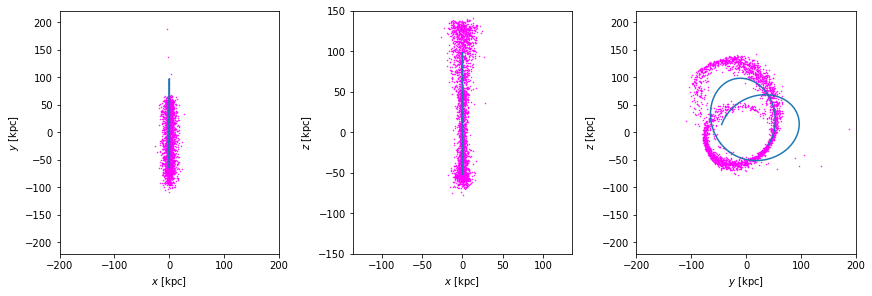

In [59]:
fig = orbit_nodrag[-1].plot(s=1, c='magenta')
_ = orbit_sat.plot(axes=fig.axes)
for ax in fig.axes:
    ax.set_xlim(-200, 200)
    ax.set_ylim(-150, 150)

Text(0.5, 1.0, 'No drag with satellite gravity')

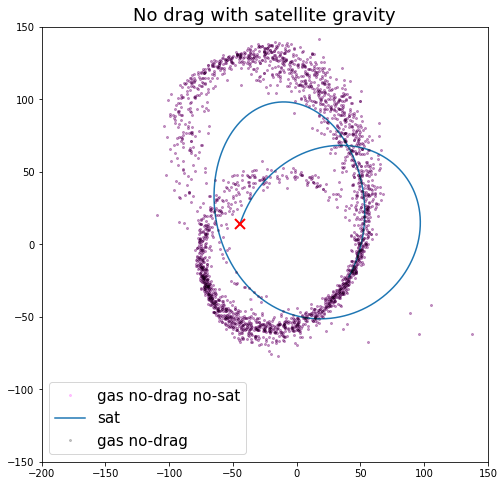

In [60]:
fig,ax = plt.subplots(1, 1, figsize=(8,8))

plt.plot(orbits_nodrag_nosat[-1].pos.y, orbits_nodrag_nosat[-1].pos.z, 'o', color='magenta', ms=2., alpha=0.2,label='gas no-drag no-sat')
ax.plot(orbit_sat_nosat.pos.y, orbit_sat_nosat.pos.z, label='sat')
plt.plot(orbits_nodrag[-1].pos.y, orbits_nodrag_nosat[-1].pos.z, 'o', color='k', ms=2., alpha=0.2,label='gas no-drag')

# ax.plot(orbit2.pos.y, orbit2.pos.z)
ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=10, markeredgewidth=2)
#ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=20, markeredgewidth=2)
ax.set(xlim=[-200,150], ylim=[-150,150])
plt.legend(fontsize=15)
plt.title("No drag with satellite gravity", fontsize=18)

In [61]:
def F_drag(t, w, f_halo, f_disk, coupling_factor):
    # position units are in kpc
    # velocity units here are in kpc/Myr
    x, y, z, vx, vy, vz = w
    
    q = np.stack((x, y, z), axis=1)
    p = np.stack((vx, vy, vz), axis=1)
    
    r = np.linalg.norm(q, axis=1)[0] # galcen distance
    R = np.sqrt(x**2 + y**2)[0] # cylindrical radius
    
    # compute acceleration from milky way:
    _t = np.array([0.])
    acc = -pot._gradient(q, _t).T
    
    col_dens = 4.6 * 10 ** 20 * 1 / u.cm**2 ## Putman+2021 -> peak density from LEO T Adams & Oosterloo + 2018
    surf_dens = (col_dens * m_p).to_value(u.Msun / u.kpc ** 2)
    #surf_dens = 1e6 * surf_dense_func(t, -age.value, 0, surf_dens0)
    
    # compute drag acceleration    
    nn = f_halo * n_mw_halo(r) + f_disk * n_mw_disk(R, z[0])
    fac = (nn * _dens_fac) / surf_dens
    acc_drag = fac * np.sum(p[0:1]**2, axis=1) # rho / Sigma * v^2
    
    # in the direction opposite of motion
    acc_drag = -acc_drag * p[0:1] / np.sqrt(np.sum(p[0:1]**2, axis=1))
    acc_drag = acc_drag.T
    
    # ---
    
    # the Cartesian unit vector in the direction of galactic rotation 
    # at the current position of the orbit
    phi = np.arctan2(y[0], x[0])
    unit_vec = -np.array([-np.sin(phi), np.cos(phi), 0])
    
    # multiply by a gaussian so this only operates near the midplane
    acc_drag[:, 0] += coupling_factor * unit_vec * np.exp(-0.5 * z[0]**2 / sigz(R)**2)
    
    # ---
    # Force from the satellite itself
#     sat = gp.HernquistPotential(m=m_star*u.Msun, c=5*u.kpc, 
#                                 units=galactic, origin=q[1])
#     sat_acc = sat.acceleration(q[0]).value[:, 0]
    acc[:, 0] = acc[:, 0] #+ sat_acc
    acc[:, 0] += acc_drag[:, 0]
    
    return np.vstack((p.T, acc))

In [62]:
# RAM pressure stripping
## parameters of the MW halo to calculate the drag
# 1) gas surface density of the SATELLITE

# for the column density in the dwarf assume
from astropy.constants import m_p
col_dens = 4.6 * 10 ** 20 * 1 / u.cm**2 ## Putman+2021 -> peak density from LEO T Adams & Oosterloo + 2018
surf_dens = (col_dens * m_p).to_value(u.Msun / u.kpc ** 2)
(col_dens * m_p).to(u.Msun / u.pc**2)
# convert to survafe density
# for unit conversion
_dens_fac = m_p.to_value(u.Msun) * (1/u.cm**3).to_value(1/u.kpc**3)


In [63]:
#gas distribution functions for halo and disc (MW)

Rsun = 8.1 # * u.kpc

# A model for the number density of the halo:
def n_mw_halo(r):
    # From Miller & Bregman 2013
    n0 = 0.46 # / u.cm**3
    rc = 0.35 # * u.kpc
    beta = 0.71
    return n0 * (1 + (r/rc)**2) ** (-1.5 * beta)


# A model for the number density of the disk:
# - Note: it flares as a function of radius, so need a 
#   function to compute the scale height at a given R
def hz(R):
    h0 = 0.15 # * u.kpc
    R0 = 9.8 # * u.kpc
    hz = h0 * np.exp((R-Rsun) / R0)
    return hz

def sigz(R):
    return 0.85 * hz(R)
    
def n_mw_disk(R, z):
    # From Kaberla review
    # s = sigz(R)
    s = hz(R)
    
    n0 = 0.9 # / u.cm**3
    Rn = 3.15 # * u.kpc
    
    # note: I added the z dependence
    # return n0 * np.exp(-(R-Rsun)/Rn) * np.exp(-0.5 * z**2 / s**2)
    return n0 * np.exp(-(R-Rsun)/Rn) * np.exp(-np.abs(z) / s)

In [64]:
magic_factor_disk = 0.8
magic_factor_halo = 1.

In [65]:
# compute the orbit  forwards
integrator = gi.DOPRI853Integrator(F_drag, func_units=galactic,
                                   func_args=(magic_factor_halo, magic_factor_disk, 0))
orbits_drag = integrator.run(gd.combine((new_ics, w0_peri)), 
                               dt=1, t1=0, t2=2*P) #dt step in Myr, from 0 to 2 orbits


In [66]:
orbit_drag = orbits_drag[:, :-1]
orbit_sat_drag = orbits_drag[:, -1]

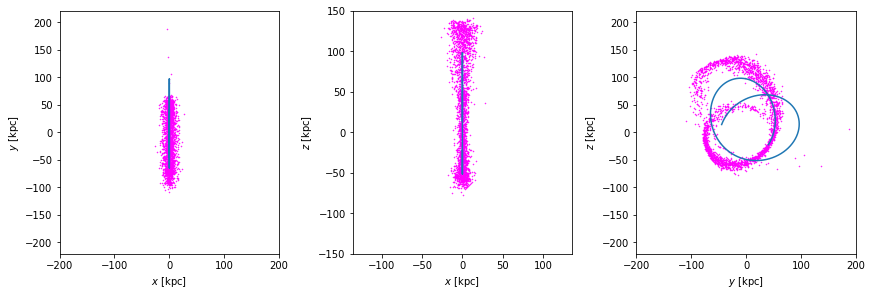

In [67]:
fig = orbit_drag[-1].plot(s=1, c='magenta')
_ = orbit_sat.plot(axes=fig.axes)
for ax in fig.axes:
    ax.set_xlim(-200, 200)
    ax.set_ylim(-150, 150)

Text(0.5, 1.0, 'RAM pressure + satellite gravity')

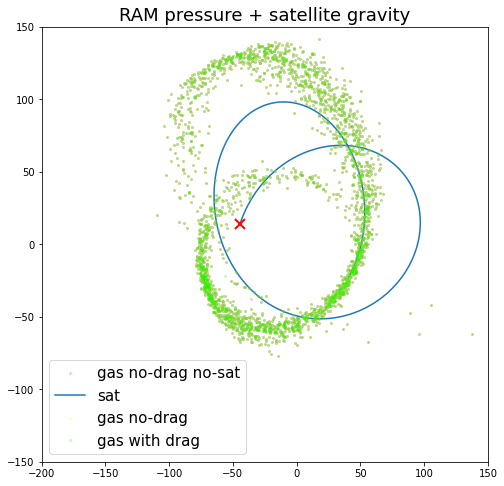

In [68]:
fig,ax = plt.subplots(1, 1, figsize=(8,8))
#fig = pot.plot_contours(grid=(grid,grid,0), cmap='Greys', ax=ax)
# fig = orbits_nodrag_nosat[-1].plot(['z', 'y'], color='magenta', s=20., alpha=0.2,
#                        axes=[ax], auto_aspect=False) 
plt.plot(orbit_nodrag_nosat[-1].pos.y, orbit_nodrag_nosat[-1].pos.z, 'o', color='magenta', ms=2., alpha=0.2,label='gas no-drag no-sat')
ax.plot(orbit_sat_nosat.pos.y, orbit_sat_nosat.pos.z, label='sat')
plt.plot(orbit_nodrag[-1].pos.y, orbit_nodrag[-1].pos.z, 'o', color='yellow', ms=2., alpha=0.2,label='gas no-drag')
plt.plot(orbit_drag[-1].pos.y, orbit_drag[-1].pos.z, 'o', color='lime', ms=2., alpha=0.2,label='gas with drag')

# ax.plot(orbit2.pos.y, orbit2.pos.z)
ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=10, markeredgewidth=2)
#ax.plot(orbit.pos.y[b], orbit.pos.z[b],'rx', ms=20, markeredgewidth=2)
ax.set(xlim=[-200,150], ylim=[-150,150])
plt.legend(fontsize=15)
plt.title("RAM pressure + satellite gravity", fontsize=18)